<a href="https://colab.research.google.com/github/mkk4726/Dacon/blob/main/TS_ML_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cesium

     |████████████████████████████████| 220 kB 4.2 MB/s 
     |████████████████████████████████| 554 kB 59.6 MB/s 
  Created wheel for gatspy: filename=gatspy-0.3-py3-none-any.whl size=43818 sha256=bf78fe94e9b7622a5c56c459b3fc0b66c68c43470f93188c4854e134fd6fafa1
  Stored in directory: /root/.cache/pip/wheels/1f/c1/4c/8de278f816259b4f67e2356c0bda260a593375661e400bf31f
Successfully built gatspy


In [2]:
from cesium import datasets

In [3]:
# EEG : 뇌전도(electroencephalogram) # ECG: 심전도 -> 시계열, 의료분야에서 많이 쓰이는 데이터, 
# 이 데이터를 사용한 논문 : https://perma.cc/YZD5-CTJF
# 눈을 뜨거나 감은 (두 개의 별도 범주) 건강한 사람에 대한 EEG 기록
# 발작이 발생하지 않은, 간질 환자의 발작과는 관련이 없는 두뇌의 두 부위에 대한 EEG 기록(두 개의 별도 범주)
# 발작 중, 뇌파 내 EEG 기록(단일범주)

# 요즘 많이 쓰이는 데이터, 핸디, 들고다니기 편하면서 수집이 쉬운 데이터, 
# 정상여부를 패턴으로 확인한다.
# 

eeg = datasets.fetch_andrzejak()

In [4]:
import matplotlib.pyplot as plt

In [23]:
type(eeg), len(eeg)

(dict, 5)

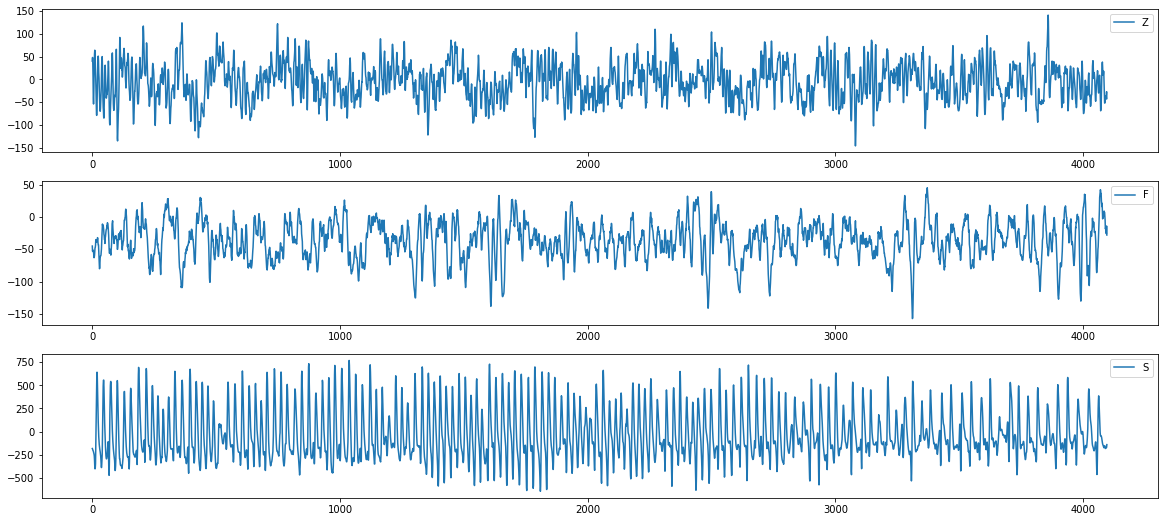

In [6]:
# 일부 샘플을 가지고 와서 그림을 그려본다
plt.figure(figsize=(20, 9))
plt.subplot(3,1,1)
plt.plot(eeg["measurements"][0])
plt.legend(eeg['classes'][0])
plt.subplot(3,1,2)
plt.plot(eeg["measurements"][300])
plt.legend(eeg['classes'][300])
plt.subplot(3,1,3)
plt.plot(eeg["measurements"][450])
plt.legend(eeg['classes'][450])

In [7]:
# cesium으로 특징을 생성하는 방법
from cesium.featurize import featurize_time_series as ft

features_to_use = ["amplitude",
                   "percent_beyond_1_std",
                   "percent_close_to_median",
                   "skew",
                   "max_slope"]

fset_cesium = ft(times = eeg["times"],
                 values = eeg["measurements"],
                 errors = None,
                 features_to_use = features_to_use,
                 scheduler = None)

In [14]:
fset_cesium['percent_beyond_1_std'][0]

0      0.327313
1      0.290212
2      0.302660
3      0.300952
4      0.305101
         ...   
495    0.368318
496    0.361728
497    0.270442
498    0.305589
499    0.225775
Name: 0, Length: 500, dtype: float64

In [8]:
fset_cesium.head()

feature,amplitude,percent_beyond_1_std,percent_close_to_median,skew,max_slope
channel,0,0,0,0,0
0,143.5,0.327313,0.505004,0.032805,11107.796610
1,211.5,0.290212,0.640469,-0.092715,20653.559322
2,165.0,0.302660,0.515987,-0.004100,13537.627119
3,171.5,0.300952,0.541128,0.063678,17008.813559
4,170.0,0.305101,0.566268,0.142753,13016.949153


In [9]:
import numpy as np
np.std(eeg["measurements"][0])

40.41100040099819

In [15]:
np.mean(eeg["measurements"][0])

-4.1320478398828415

In [16]:
sample_ts = eeg["measurements"][0]
sz = len(sample_ts)
ll = -4.13 - 40.4 # u - std
ul = -4.13 + 40.4 # u +std
quals = [i for i in range(sz) if sample_ts[i] < ll or sample_ts[i] > ul]

In [17]:
len(quals)/sz

0.3273126678057115

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(fset_cesium.values, eeg["classes"], random_state=21)

In [19]:
## 1. Random Forest ##
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators = 10,
                                max_depth = 3,
                                random_state = 21, )
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10, random_state=21)

In [20]:
# 학습에 사용되지 않은 데이터에 대한 정확도를 반환
rf_clf.score(X_test, y_test)

0.616

In [24]:
## XGBoost ##

import xgboost as xgb
xgb_clf = xgb.XGBClassifier(n_estimators = 10,
                            max_depth = 3,
                            random_state = 21)

xgb_clf.fit(X_train, y_train)
xgb_clf.score(X_test, y_test)

0.648

In [25]:
# 학습에 소요되는 시간 반환

import time

start = time.time()
xgb_clf.fit(X_train, y_train)
end = time.time()
end - start

0.023396015167236328

In [26]:
start = time.time()
rf_clf.fit(X_train, y_train)
end = time.time()
end - start

0.02048969268798828

In [27]:
xgb_clf = xgb.XGBClassifier(n_estimators = 10,
                            max_depth = 2,
                            random_state = 21)
xgb_clf.fit(X_train, y_train)
xgb_clf.score(X_test, y_test)

0.616

In [34]:
rf_clf = RandomForestClassifier(n_estimators = 2000,
                                max_depth = 2,
                                random_state = 21)
rf_clf.fit(X_train, y_train)
rf_clf.score(X_test, y_test)

0.584

In [29]:
xgb_clf = xgb.XGBClassifier(n_estimators = 10,
                            max_depth = 1,
                            random_state = 21)
xgb_clf.fit(X_train, y_train)
xgb_clf.score(X_test, y_test)

0.632

In [33]:
xgb_clf = xgb.XGBClassifier(n_estimators = 2000,
                            max_depth = 1,
                            random_state = 21)
xgb_clf.fit(X_train, y_train)
xgb_clf.score(X_test, y_test)

0.648

In [30]:
rf_clf = RandomForestClassifier(n_estimators = 10,
                                max_depth = 1,
                                random_state = 21)
rf_clf.fit(X_train, y_train)
rf_clf.score(X_test, y_test)

0.376